#**Loading packages**


In [ ]:
# Install packages
!pip install scanpy scipy umap-learn leidenalg scFates
!pip install hmmlearn


In [ ]:
import os, sys
os.environ['R_HOME'] = sys.exec_prefix+"/lib/R/"
import scanpy as sc
import scFates as scf
import numpy as np
import pandas as pd
from anndata import AnnData
from typing import Dict, Tuple
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from scipy.sparse import issparse


In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load data
adata = sc.read_h5ad("/content/drive/My Drive/Colab Notebooks/Computational Stem Cells/adata_used.h5ad")


In [ ]:
adata.var["gene_name"] = adata.var.index
adata.var

,gene_ids,feature_types,genome,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,chromosome,start,end,strand,gene_name
original_index,,,,,,,,,,,,,,,
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,False,60,0.005183,99.490186,61.0,60,NaN,NaN,NaN,NaN,AL627309.1
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,False,False,4,0.000340,99.966012,4.0,4,1,89551.0,91105.0,-1.0,AL627309.3
AL669831.5,ENSG00000237491,Gene Expression,GRCh38,False,False,679,0.062367,94.230606,734.0,673,1,778739.0,810066.0,1.0,AL669831.5
FAM87B,ENSG00000177757,Gene Expression,GRCh38,False,False,13,0.001190,99.889540,14.0,13,1,817363.0,819842.0,1.0,FAM87B
LINC00115,ENSG00000225880,Gene Expression,GRCh38,False,False,350,0.031269,97.026085,368.0,340,1,586945.0,827989.0,-1.0,LINC00115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC011043.1,ENSG00000276256,Gene Expression,GRCh38,False,False,77,0.006882,99.345739,81.0,75,GL000195.1,42939.0,49164.0,-1.0,AC011043.1
AL592183.1,ENSG00000273748,Gene Expression,GRCh38,False,False,32,0.002719,99.728099,32.0,31,GL000219.1,54224.0,83311.0,-1.0,AL592183.1
AC007325.4,ENSG00000278817,Gene Expression,GRCh38,False,False,239,0.020902,97.969241,246.0,235,KI270734.1,131494.0,137392.0,1.0,AC007325.4


In [ ]:
adata

AnnData object with n_obs × n_vars = 10309 × 20104
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'cell_type', 'simulated_cnvs'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'chromosome', 'start', 'end', 'strand', 'gene_name'
    layers: 'counts'

In [ ]:
# Drop rows with missing genomic info (e.g., 'start' or 'end')
adata = adata[:, ~adata.var["start"].isna()].copy()

#**Finding Reference Cluster**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import issparse

def plot_cluster_means_by_genomic_position(adata, layer="counts", group_by="cell_type", downsample=100):
    """
    Plots mean expression across genomic positions for each group in `adata`.

    Parameters:
    - adata: AnnData object with `layers[layer]` and `obs[group_by]` defined.
    - layer: Layer name containing count data.
    - group_by: Column in `adata.obs` to group cells (e.g., "cell_type").
    - downsample: Plot every nth gene to reduce visual clutter.
    """
    gene_indices = np.arange(0, adata.n_vars, downsample)

    # Get chromosome info if available
    chromosomes = adata.var["chromosome"].values[gene_indices] if "chromosome" in adata.var else None

    if chromosomes is not None:
        valid_chroms = [str(i) for i in range(1, 23)] + ['X', 'chrX']
        chrom_mask = np.isin(chromosomes, valid_chroms)
        chrom_changes = np.where((chromosomes[:-1] != chromosomes[1:]) &
                                 (chrom_mask[:-1] | chrom_mask[1:]))[0] + 1
        chrom_boundaries = [0] + chrom_changes.tolist() + [len(chromosomes)]
        chrom_midpoints = [(chrom_boundaries[i] + chrom_boundaries[i+1]) // 2
                           for i in range(len(chrom_boundaries)-1)]
        chrom_labels = [chromosomes[i] for i in chrom_boundaries[:-1]]

    # Calculate global Y-axis limits
    all_means = []
    for group in adata.obs[group_by].unique():
        group_mask = adata.obs[group_by] == group
        group_data = adata[group_mask].layers[layer][:, gene_indices]
        if issparse(group_data):
            group_data = group_data.toarray()
        all_means.append(np.mean(group_data, axis=0))

    global_ymin = min(np.min(means) for means in all_means)
    global_ymax = max(np.max(means) for means in all_means)
    y_padding = (global_ymax - global_ymin) * 0.1

    # 1. Combined Plot
    plt.figure(figsize=(14, 6))
    for group, means in zip(adata.obs[group_by].unique(), all_means):
        plt.plot(means, label=f"{group}", linewidth=1)

    if chromosomes is not None:
        for x in chrom_boundaries[1:-1]:
            if chrom_mask[x]:
                plt.axvline(x, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
        plt.xticks(
            [mp for mp, lbl in zip(chrom_midpoints, chrom_labels) if lbl in valid_chroms],
            [lbl for lbl in chrom_labels if lbl in valid_chroms],
            rotation=90
        )

    plt.ylim(global_ymin - y_padding, global_ymax + y_padding)
    plt.title(f"All Groups (Downsampled {downsample}x)")
    plt.xlabel("Genomic Position")
    plt.ylabel("Mean Counts")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

    # 2. Individual Group Plots
    for group, means in zip(adata.obs[group_by].unique(), all_means):
        plt.figure(figsize=(14, 4))
        plt.plot(means, color='steelblue', linewidth=1)

        if chromosomes is not None:
            for x in chrom_boundaries[1:-1]:
                if chrom_mask[x]:
                    plt.axvline(x, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
            plt.xticks(
                [mp for mp, lbl in zip(chrom_midpoints, chrom_labels) if lbl in valid_chroms],
                [lbl for lbl in chrom_labels if lbl in valid_chroms],
                rotation=90
            )

        plt.ylim(global_ymin - y_padding, global_ymax + y_padding)
        plt.title(f"Group: {group}\n(Mean Expression, {downsample}x downsampled)")
        plt.xlabel("Genomic Position")
        plt.ylabel("Mean Counts")
        plt.tight_layout()
        plt.show()

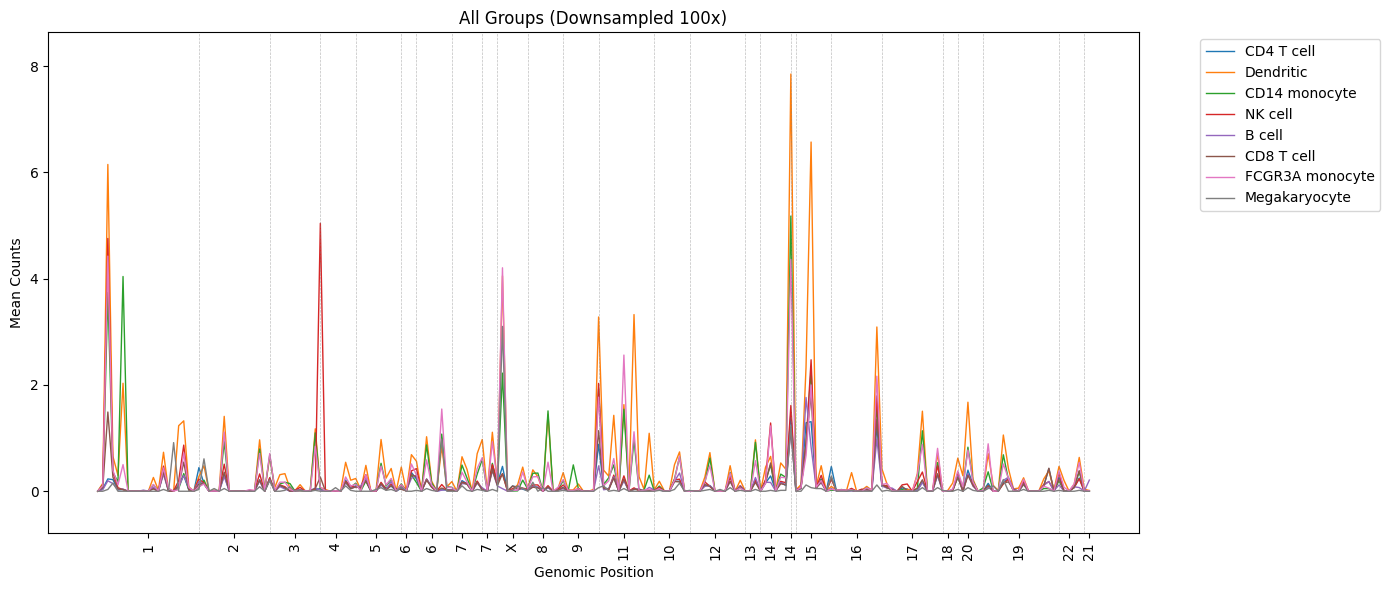

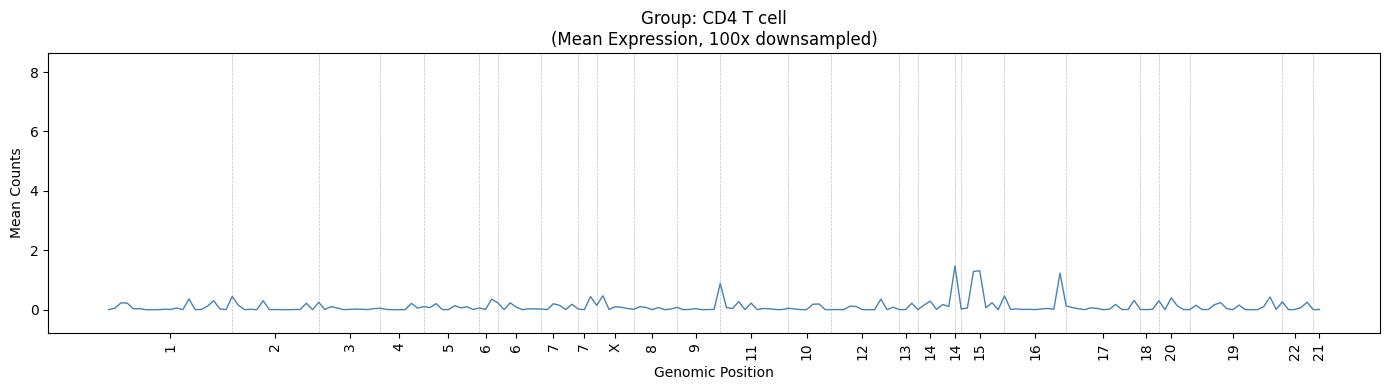

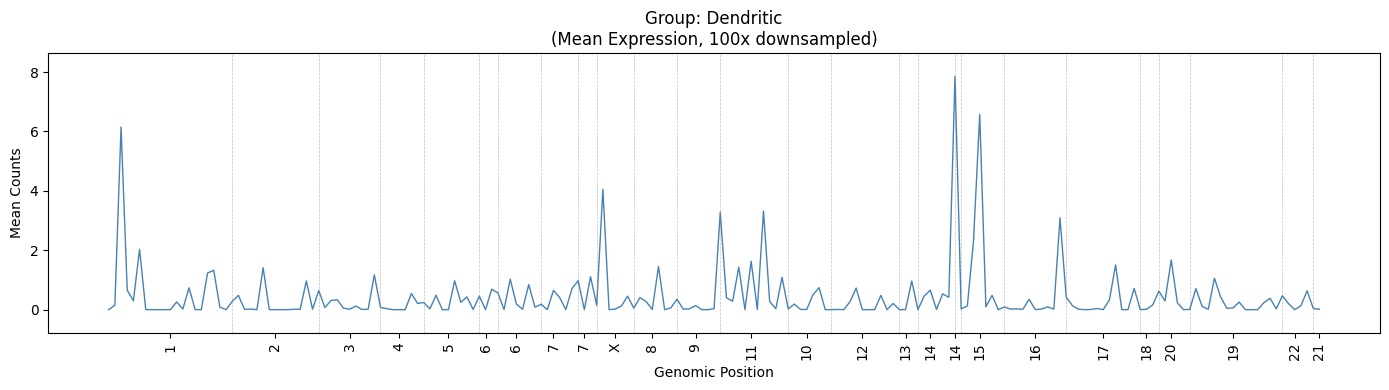

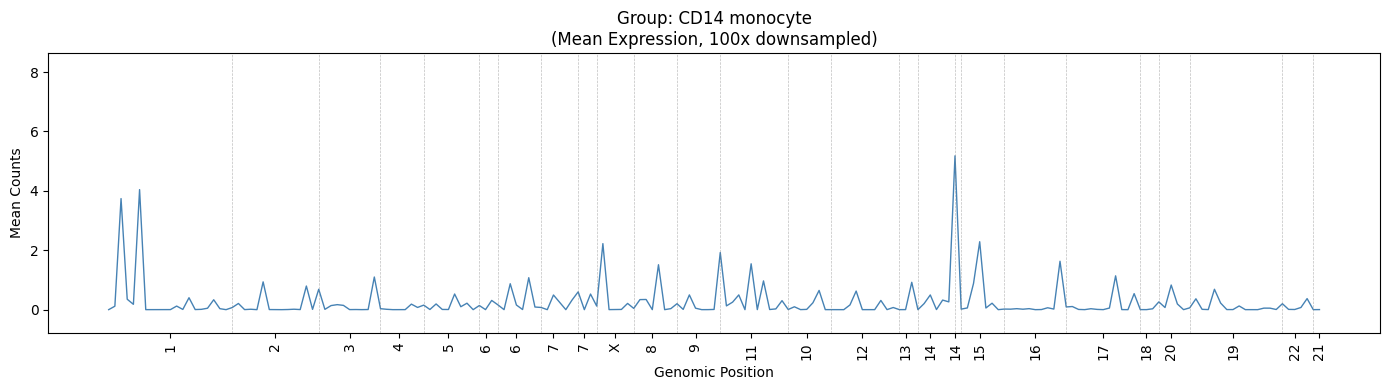

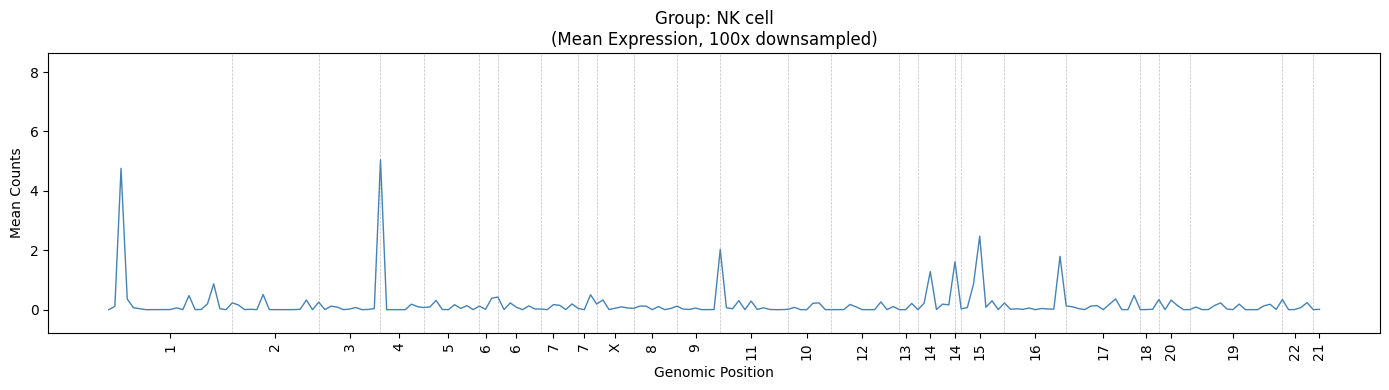

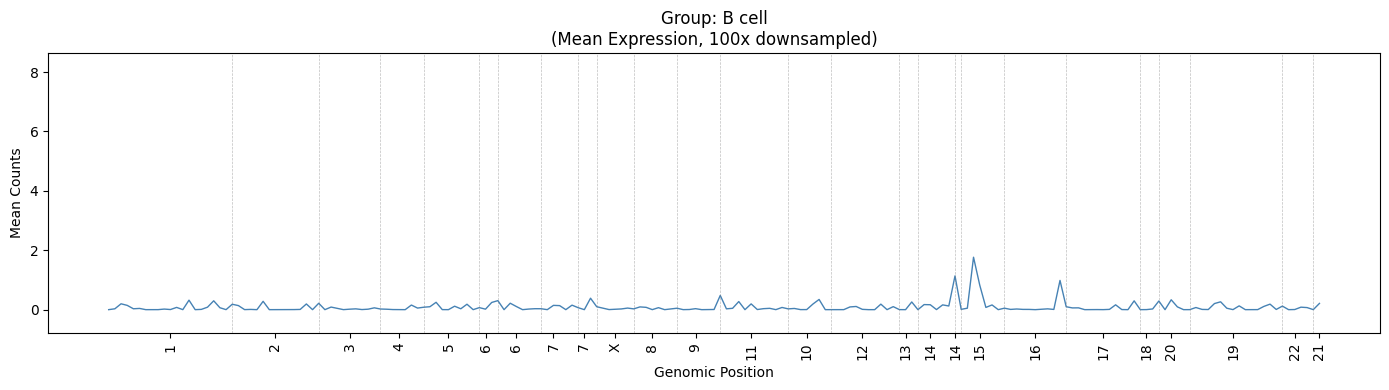

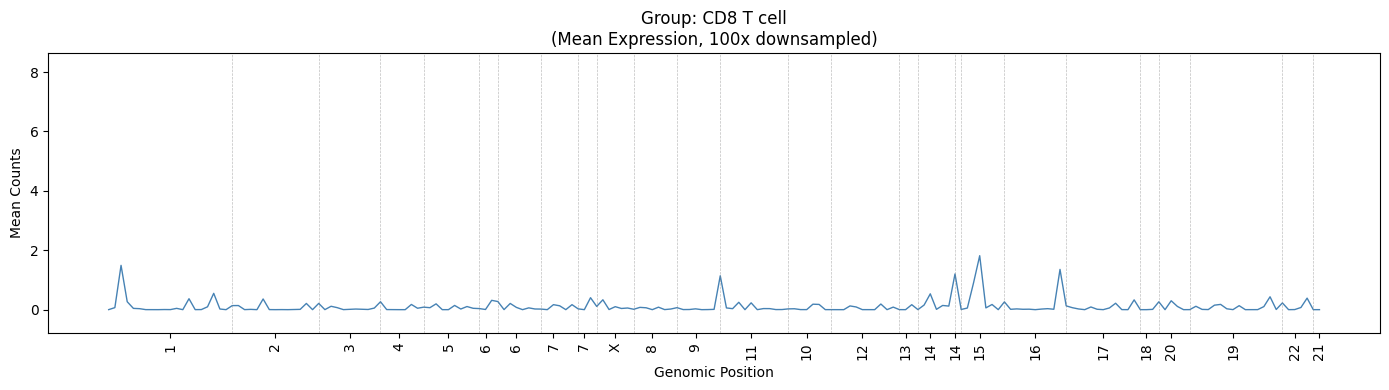

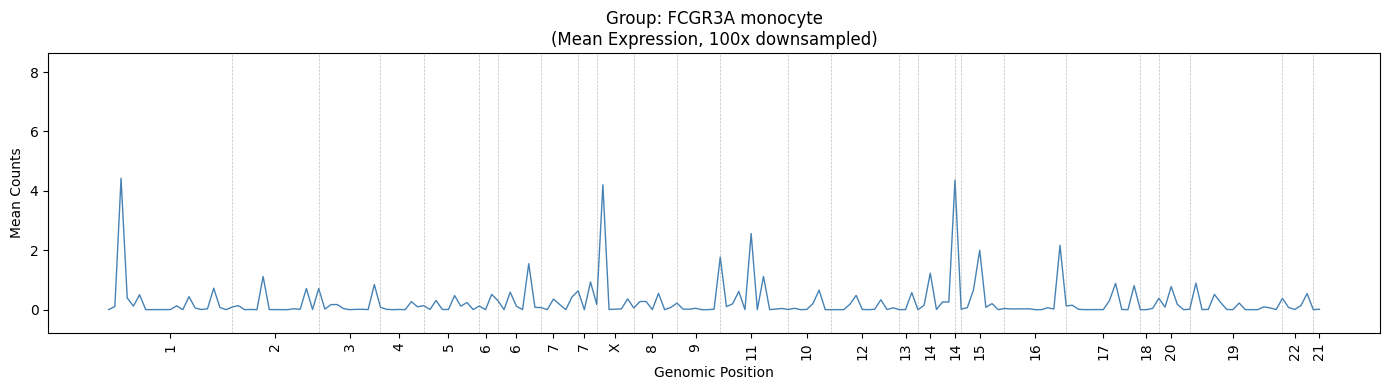

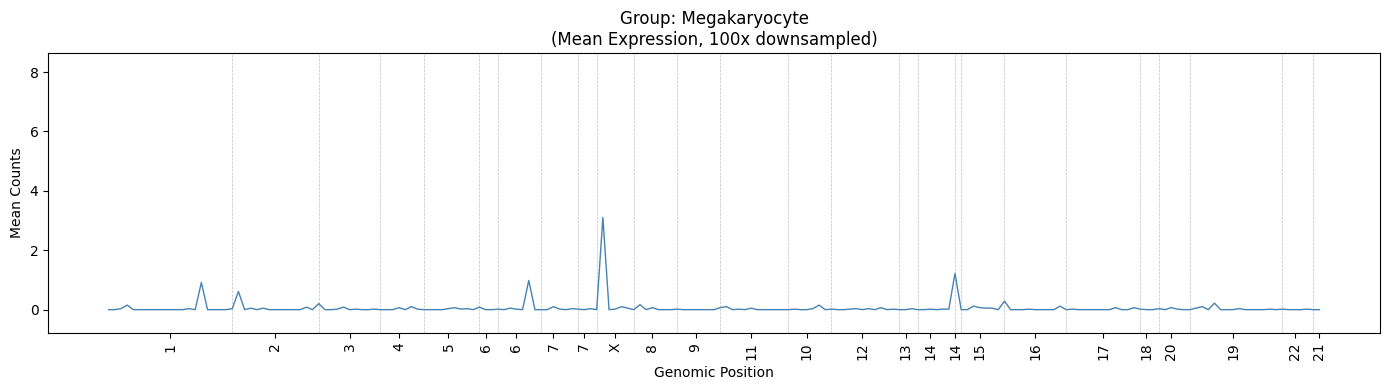

In [ ]:
#run function to find reference cluster
plot_cluster_means_by_genomic_position(adata, layer="counts", downsample=100)


In [ ]:
# B cell seems to have lowest baseline expression

#**Smoothing (2)**

In [ ]:
def order_genes_by_position(adata: AnnData) -> AnnData:
    """
    Orders the variables (genes) in the AnnData object by chromosome and start.
    """
    gene_order = (
        adata.var
        .sort_values(['chromosome', 'start'])
        .index
    )
    return adata[:, gene_order]


def smooth_expression_matrix(matrix: pd.DataFrame, window_size: int = 25) -> pd.DataFrame:
    """
    Applies a sliding window average across genes.
    """
    smoothed = []
    gene_names = matrix.columns.to_list()

    for i in range(len(gene_names) - window_size + 1):
        window = gene_names[i:i + window_size]
        avg_expr = matrix[window].mean(axis=1)
        smoothed.append(avg_expr.rename(f"{window[0]}_to_{window[-1]}"))

    return pd.concat(smoothed, axis=1)



def compute_smoothed_profiles_from_adata(
    adata: AnnData,
    use_layer: str = None,
    group_by: str = 'cell_type',
    window_size: int = 25,
    ref: str = 'Monocyte'
) -> Tuple[pd.DataFrame, Dict[str, pd.Series], pd.Series, pd.Series]:
    """
    Computes smoothed expression profiles from an AnnData object.
    Returns:
    - Per-cell smoothed expression DataFrame
    - Dictionary of per-cell-type smoothed average Series
    - Global average Series
    - Reference cluster average Series
    """
    # Step 1: Order genes
    adata_ordered = order_genes_by_position(adata)

    # Step 2: Get expression matrix
    if use_layer:
        expr = pd.DataFrame(
            adata_ordered.layers[use_layer].toarray(),
            index=adata_ordered.obs_names,
            columns=adata_ordered.var_names
        )
    else:
        expr = pd.DataFrame(
            adata_ordered.X.toarray() if hasattr(adata_ordered.X, "toarray") else adata_ordered.X,
            index=adata_ordered.obs_names,
            columns=adata_ordered.var_names
        )

    # Step 3: Smooth once for all cells
    smoothed_expr = smooth_expression_matrix(expr, window_size)

    # Step 4: Global average
    global_avg = smoothed_expr.mean(axis=0)

    # Step 5: Per-cell-type averages (vectorized)
    celltypes = adata_ordered.obs[group_by]
    celltype_profiles = {
        ct: smoothed_expr.loc[celltypes == ct].mean(axis=0)
        for ct in celltypes.unique()
    }

    # Step 6: Reference cluster average
    if ref in celltype_profiles:
        cluster_avg = celltype_profiles[ref]
    else:
        raise ValueError(f"Reference cell type '{ref}' not found in adata.obs['{group_by}'].")

    return smoothed_expr, celltype_profiles, global_avg, cluster_avg


In [ ]:
# Perform smothing with comput_smoothed_profiles_from_adata (other 2 functions are already called within this function)
smoothed, celltype_avg, global_avg, cluster_avg = compute_smoothed_profiles_from_adata(adata, group_by = "cell_type", ref = "B cell")

In [ ]:
def compute_all_cell_zscores_to_adata_optimized(smoothed: pd.DataFrame,
                                                celltype_avg: dict,
                                                global_avg: pd.Series,
                                                cluster_avg: pd.Series,
                                                adata: AnnData,
                                                group_by: str = 'cell_type') -> AnnData:
    """
    Optimized memory-efficient version to compute z-score deltas and store them in `adata.obsm`.

    will store as adata.obsm['delta_global_z'], adata.obsm['delta_celltype_z'], adata.obsm['delta_cluster_z']
    """

    cells = smoothed.index
    genes = smoothed.columns
    n_cells, n_genes = smoothed.shape

    # Precompute arrays for faster access
    smoothed_np = smoothed.values
    global_avg_np = global_avg.values
    cluster_avg_np = cluster_avg.values

    # Build a matrix of per-cell-type averages aligned to cells
    group = adata.obs.loc[cells, group_by].values
    celltype_avg_np = np.stack([celltype_avg[ct].loc[genes].values for ct in group])

    # Allocate arrays
    delta_global_z = np.zeros_like(smoothed_np)
    delta_celltype_z = np.zeros_like(smoothed_np)
    delta_cluster_z = np.zeros_like(smoothed_np)

    # Helper function: z-score along gene axis (per cell)
    def zscore_rowwise(matrix):
        mean = matrix.mean(axis=1, keepdims=True)
        std = matrix.std(axis=1, keepdims=True)
        std[std == 0] = 1  # prevent division by zero
        return (matrix - mean) / std

    # Compute deltas
    delta_global = smoothed_np - global_avg_np
    delta_celltype = smoothed_np - celltype_avg_np
    delta_cluster = smoothed_np - cluster_avg_np

    # Z-score normalize each row (cell)
    delta_global_z = zscore_rowwise(delta_global)
    delta_celltype_z = zscore_rowwise(delta_celltype)
    delta_cluster_z = zscore_rowwise(delta_cluster)

    # Store results in adata.obsm
    adata.obsm['delta_global_z'] = delta_global_z
    adata.obsm['delta_celltype_z'] = delta_celltype_z
    adata.obsm['delta_cluster_z'] = delta_cluster_z
    adata.uns['delta_zscore_genes'] = list(genes)

    return adata


In [ ]:
# run fuction to compute z scores against 3 different references (global, celltype, and reference cluster)
adata= compute_all_cell_zscores_to_adata_optimized(smoothed, celltype_avg, global_avg, cluster_avg, adata, group_by = "cell_type")


In [ ]:
def filter_and_count_zscores(
    zscore_array,
    upper_thresh: float = 1.0,
    lower_thresh: float = -1.0,
    min_cells: int = 600,
    adata: AnnData = None,
    obsm_key: str = None
) -> Tuple[pd.DataFrame, pd.Series, pd.Series]:
    """
    Robust z-score filtering with proper AnnData alignment

    Parameters:
        zscore_array: Input array (cells × genes)
        upper_thresh/lower_thresh: Significance thresholds
        min_cells: Minimum cells with significant changes
        adata: AnnData object (must match zscore_array rows)
        obsm_key: Key for storing filtered matrix in adata.obsm

    Returns:
        Tuple of (filtered_df, up_counts, down_counts)
    """

    # Validate dimensions
    if adata is not None:
        if zscore_array.shape[0] != adata.n_obs:
            raise ValueError(f"zscore_array has {zscore_array.shape[0]} cells, adata has {adata.n_obs}")

    # Convert to DataFrame with proper gene names
    zscore_df = pd.DataFrame(
        zscore_array,
        index=adata.obs_names if adata else None,
        columns=adata.var_names[:zscore_array.shape[1]] if adata else None
    )

    # Create significance masks
    sig_mask = (zscore_df > upper_thresh) | (zscore_df < lower_thresh)
    sig_counts = sig_mask.sum(axis=0)  # Count per gene

    # Filter genes
    keep_genes = sig_counts >= min_cells
    filtered_df = zscore_df.where(sig_mask & keep_genes, None)

    # Store in AnnData if requested
    if adata is not None and obsm_key is not None:
        # Create full-sized matrix aligned with adata.var
        filtered_matrix = np.zeros((adata.n_obs, adata.n_vars))
        filtered_matrix[:, :zscore_array.shape[1]] = filtered_df.values
        adata.obsm[obsm_key] = filtered_matrix

        # Store which genes were kept
        adata.uns[f"{obsm_key}_genes"] = filtered_df.columns.tolist()

    # Count significant events
    up_counts = (zscore_df > upper_thresh).sum(axis=0)
    down_counts = (zscore_df < lower_thresh).sum(axis=0)

    print(f"Filtered to {keep_genes.sum()} genes with changes in ≥{min_cells} cells")
    return filtered_df.loc[:, keep_genes], up_counts, down_counts

In [ ]:
# Filter all 3 z-scores (global, celltype, reference cluster)
filtered, up, down = filter_and_count_zscores(
    adata.obsm["delta_global_z"],
    upper_thresh=1.5,
    lower_thresh=-1.5,
    min_cells=600,
    adata=adata,
    obsm_key="filtered_global_z"
)

filtered, up, down = filter_and_count_zscores(
    adata.obsm["delta_celltype_z"],
    upper_thresh=1.5,
    lower_thresh=-1.5,
    min_cells=600,
    adata=adata,
    obsm_key="filtered_celltype_z"
)

filtered, up, down = filter_and_count_zscores(
    adata.obsm["delta_cluster_z"],
    upper_thresh=1.5,
    lower_thresh=-1.5,
    min_cells=600,
    adata=adata,
    obsm_key="filtered_cluster_z"
)

Filtered to 1008 genes with changes in ≥600 cells
Filtered to 1955 genes with changes in ≥600 cells
Filtered to 1642 genes with changes in ≥600 cells


#**HMM modeling and CNVs**

In [ ]:
def detect_cnvs_with_hmm_final(adata, matrix_name="filtered_z", n_components=3,
                             n_iter=50, random_state=42, output_prefix="hmm_cnv",
                             min_non_nan=20, chunk_size=100):
    """
    Final robust HMM implementation that:
    1. Uses pre-initialized model parameters
    2. Handles sparse data gracefully
    3. Provides detailed error reporting
    4. Stores per-gene HMM state and posterior in adata.var
    """

    if matrix_name not in adata.obsm:
        raise ValueError(f"Matrix '{matrix_name}' not found in adata.obsm")

    data = adata.obsm[matrix_name]
    n_cells, n_features = data.shape

    all_states = np.full(n_features, -1, dtype=np.int8)
    all_posteriors = np.full((n_features, n_components), np.nan, dtype=np.float16)

    print("Identifying valid features...")
    valid_features = [f for f in range(n_features) if np.sum(~np.isnan(data[:, f])) >= min_non_nan]

    if len(valid_features) < n_components:
        raise ValueError(f"Only {len(valid_features)} valid features found - need at least {n_components} for HMM")

    # Initialize HMM model
    model = hmm.GaussianHMM(
        n_components=n_components,
        covariance_type="diag",
        n_iter=0,
        init_params="",
        means_prior=np.linspace(-2, 2, n_components).reshape(-1, 1),
        covars_prior=np.ones((n_components, 1)),
        transmat_prior=np.full((n_components, n_components), 1/n_components),
        random_state=random_state
    )

    model_fitted = False

    print("Processing in chunks...")
    for chunk_start in tqdm(range(0, len(valid_features), chunk_size)):
        chunk_features = valid_features[chunk_start:chunk_start + chunk_size]
        chunk = data[:, chunk_features]

        valid_cells = ~np.isnan(chunk).any(axis=1)
        clean_chunk = chunk[valid_cells, :]

        if clean_chunk.shape[0] < min_non_nan:
            continue

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            scaled_chunk = StandardScaler().fit_transform(clean_chunk)

        if not model_fitted:
            try:
                model.n_iter = n_iter
                model.fit(scaled_chunk.T)
                model_fitted = True
                print("Model successfully fitted!")
            except Exception as e:
                print(f"Fit failed: {str(e)}")
                continue

        try:
            states = model.predict(scaled_chunk.T)
            posteriors = model.predict_proba(scaled_chunk.T)

            for i, f in enumerate(chunk_features):
                all_states[f] = states[i]
                all_posteriors[f] = posteriors[i].astype(np.float16)
        except Exception as e:
            print(f"Prediction failed for chunk {chunk_start}: {str(e)}")
            continue

    if not model_fitted:
        raise RuntimeError("Could not fit HMM to any data chunks")

    # Store in adata.var
    adata.var[f"{output_prefix}_state"] = -1
    for i in range(n_components):
        adata.var[f"{output_prefix}_prob_state_{i}"] = np.nan

    for idx, gene in enumerate(adata.var_names):
        adata.var.loc[gene, f"{output_prefix}_state"] = int(all_states[idx])
        for i in range(n_components):
            adata.var.loc[gene, f"{output_prefix}_prob_state_{i}"] = all_posteriors[idx, i]

    print("Stored HMM states and posteriors in adata.var")
    return adata


In [ ]:
# Run single-cell CNV detection and HMM classification
adata = detect_cnvs_with_hmm_final(adata, matrix_name="filtered_cluster_z", n_components=3,
                             n_iter=50, random_state=42, output_prefix="hmm_cnv",
                             min_non_nan=20, chunk_size=100
)



Identifying valid features...
Processing in chunks...


 47%|████▋     | 8/17 [00:00<00:00, 11.71it/s]

Model successfully fitted!


100%|██████████| 17/17 [00:00<00:00, 18.89it/s]


Prediction failed for chunk 1600: operands could not be broadcast together with shapes (66,1,536) (3,30) 
Stored HMM states and posteriors in adata.var


In [ ]:
def format_detected_cnvs_with_cell_counts(
    adata,
    state_col='hmm_cnv_state',
    output_col='detected_cnvs',
    chrom_col='chromosome',
    start_col='start',
    end_col='end',
    group_by_col='cell_type',
    max_gap=1e6,
    min_region_size=1000,
    z_threshold=1.5
):
    """
    Formats detected CNVs:
    - Excludes neutral regions
    - Merges overlapping CNVs
    - Counts affected cells per region and cell type
    - Annotates CNV type (gain/loss)
    """

    import pandas as pd
    import numpy as np
    from scipy.stats import zscore
    import warnings

    # Only consider CNV states (not neutral)
    valid_states = [0, 2]
    valid_features = adata.var[state_col].isin(valid_states)
    sorted_vars = adata.var[valid_features].sort_values([chrom_col, start_col])

    if len(sorted_vars) == 0:
        print("No CNV regions found!")
        adata.obs[output_col] = "neutral"
        return adata, pd.DataFrame()

    # Map state to CN type
    state_to_cn = {
        0: '0',   # Deletion
        2: '4'    # Amplification
    }
    cn_to_type = {
        '0': 'loss',
        '4': 'gain'
    }

    # Build regions list
    regions = []
    for _, row in sorted_vars.iterrows():
        cn = state_to_cn[row[state_col]]
        regions.append({
            'chrom': row[chrom_col],
            'start': float(row[start_col]),
            'end': float(row[end_col]),
            'cn': cn,
            'cnv_type': cn_to_type[cn],
            'genes': [row.name]
        })

    # Merge overlapping CNVs
    merged = []
    current = None

    for region in sorted(regions, key=lambda x: (x['chrom'], x['start'])):
        if current is None:
            current = region.copy()
            continue

        if (
            region['chrom'] == current['chrom']
            and region['cn'] == current['cn']
            and region['start'] <= current['end'] + max_gap
        ):
            current['end'] = max(current['end'], region['end'])
            current['genes'].extend(region['genes'])
        else:
            if current['end'] - current['start'] >= min_region_size:
                merged.append(current)
            current = region.copy()

    if current and current['end'] - current['start'] >= min_region_size:
        merged.append(current)

    if not merged:
        print("No valid CNV regions after merging.")
        adata.obs[output_col] = "neutral"
        return adata, pd.DataFrame()

    # Create CNV matrix and collect stats
    results = []
    cell_cnv_matrix = np.zeros((adata.n_obs, len(merged)), dtype=bool)

    for i, region in enumerate(merged):
        expr = adata[:, region['genes']].X
        if hasattr(expr, 'toarray'):
            expr = expr.toarray()

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            z_scores = zscore(expr, axis=0, nan_policy='omit')
            region_z = np.nanmean(z_scores, axis=1)

        # Determine affected cells
        if region['cn'] == '0':
            cnv_cells = region_z < -z_threshold
        elif region['cn'] == '4':
            cnv_cells = region_z > z_threshold
        else:
            cnv_cells = np.zeros(adata.n_obs, dtype=bool)

        cell_cnv_matrix[:, i] = cnv_cells
        n_cells = np.sum(cnv_cells)

        # Count by cell type
        if group_by_col in adata.obs.columns:
            cell_types = adata.obs.loc[cnv_cells, group_by_col]
            cell_type_counts = cell_types.value_counts().to_dict()
        else:
            cell_type_counts = {}

        region_str = f"{region['chrom']}:{int(region['start'])}-{int(region['end'])} (CN {region['cn']})"

        results.append({
            'region': region_str,
            'n_cells': n_cells,
            'genes': ','.join(region['genes']),
            'cnv_type': region['cnv_type'],
            'group_by_counts': cell_type_counts
        })

    # Final DataFrame
    cnv_df = pd.DataFrame(results).sort_values('n_cells', ascending=False)
    cnv_df['percent_cells'] = (cnv_df['n_cells'] / adata.n_obs * 100).round(1)

    # Assign CNVs to cells
    adata.obs[output_col] = "neutral"
    for i in range(len(merged)):
        region_str = cnv_df.iloc[i]['region']
        adata.obs.loc[cell_cnv_matrix[:, i], output_col] = region_str

    # Handle multiple CNVs per cell
    multi_cnv_cells = np.sum(cell_cnv_matrix, axis=1) > 1
    if np.any(multi_cnv_cells):
        for cell_idx in np.where(multi_cnv_cells)[0]:
            patterns = [
                cnv_df.iloc[i]['region']
                for i in np.where(cell_cnv_matrix[cell_idx])[0]
            ]
            adata.obs.iloc[cell_idx, adata.obs.columns.get_loc(output_col)] = "; ".join(patterns)

    print(f"Detected {len(merged)} CNV regions across {np.sum(cell_cnv_matrix)} cell-region pairs")
    print("\nTop CNV regions by cell count:")
    print(cnv_df.head())

    # Store extra info
    adata.uns['cnv_stats'] = {
        'total_regions': len(merged),
        'total_cell_cnv_pairs': np.sum(cell_cnv_matrix),
        'cells_with_cnvs': np.sum(adata.obs[output_col] != "neutral"),
        'cell_cnv_matrix': cell_cnv_matrix,
        'merged_regions': merged
    }

    return adata, cnv_df


In [ ]:
# Formating the results into a table to detect which chromosome and location is CNV
adata, cnv_stats = format_detected_cnvs_with_cell_counts(
    adata,
    state_col='hmm_cnv_state',
    group_by_col='cell_type',
    max_gap=500000,
    min_region_size=5000,
    z_threshold=1.5
)




Detected 4 CNV regions across 500 cell-region pairs

Top CNV regions by cell count:
                                      region  n_cells  \
2  HSCHR6_MHC_MANN_CTG1:180335-189548 (CN 4)      383   
3  HSCHR6_MHC_QBL_CTG1:922481-1093907 (CN 4)      103   
0                 6:27808173-29949572 (CN 4)       14   
1                 6:42564029-43161719 (CN 0)        0   

                                               genes cnv_type  \
2                                             TRIM27     gain   
3                                    MOG,HLA-F,HLA-G     gain   
0  HIST1H2AI,HIST1H3H,HIST1H2AJ,HIST1H2BM,HIST1H4...     gain   
1  UBR2,PRPH2,TBCC,BICRAL,C6orf226,PTCRA,CNPY3,AL...     loss   

                                     group_by_counts  percent_cells  
2  {'CD14 monocyte': 223, 'CD4 T cell': 67, 'FCGR...            3.7  
3  {'CD14 monocyte': 36, 'CD4 T cell': 31, 'CD8 T...            1.0  
0  {'CD4 T cell': 6, 'CD8 T cell': 2, 'Dendritic'...            0.1  
1  {'B cell': 0, 'CD14 m

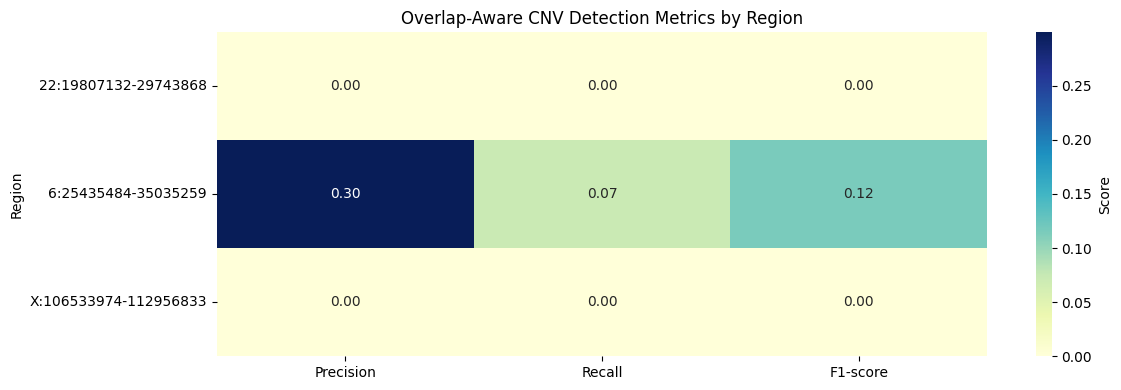

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import re

# Helper: parse region strings like '22:19807132-29743868 (CN 0)'
def parse_region(region_str):
    match = re.match(r'(\w+):(\d+)-(\d+)', region_str.strip())
    if match:
        chrom, start, end = match.groups()
        return chrom, int(start), int(end)
    return None

# Helper: check overlap
def overlaps(region1, region2):
    if region1 is None or region2 is None:
        return False
    c1, s1, e1 = region1
    c2, s2, e2 = region2
    return c1 == c2 and max(s1, s2) <= min(e1, e2)

# Extract CNV strings
simulated = adata.obs["simulated_cnvs"].fillna("").astype(str)
detected = adata.obs["detected_cnvs"].fillna("").astype(str)

# Convert to sets of parsed regions
def extract_and_parse(cnv_string):
    if cnv_string == 'neutral' or cnv_string.strip() == '':
        return set()
    regions = [x.strip() for x in cnv_string.split(',')]
    return set(parse_region(r) for r in regions if parse_region(r))

simulated_parsed = simulated.apply(extract_and_parse)
detected_parsed = detected.apply(extract_and_parse)

# Collect all unique simulated regions
all_sim_regions = set()
for regions in simulated_parsed:
    all_sim_regions.update(regions)

# Initialize metric storage
metrics = {'Region': [], 'Precision': [], 'Recall': [], 'F1-score': []}

# For each simulated region, check for overlapping detected regions
for region in sorted(all_sim_regions):
    y_true = simulated_parsed.apply(lambda s: region in s).astype(int)
    y_pred = detected_parsed.apply(
        lambda s: any(overlaps(region, d) for d in s)
    ).astype(int)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    label = f"{region[0]}:{region[1]}-{region[2]}"
    metrics['Region'].append(label)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1-score'].append(f1)

# Create DataFrame
metrics_df = pd.DataFrame(metrics).set_index('Region')

# Plot heatmap
plt.figure(figsize=(12, max(4, len(metrics_df)//4)))
sns.heatmap(metrics_df, annot=True, cmap='YlGnBu', fmt=".2f", cbar_kws={'label': 'Score'})
plt.title("Overlap-Aware CNV Detection Metrics by Region")
plt.tight_layout()
plt.show()
